In [1]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

# Load data

In [2]:
X = pd.read_csv('./data/hcvdat0.csv', index_col=0).reset_index(drop=True)

# Pre-processing

In this first part, we need to change the ``category`` attribute of the data because we need it to be int. In addition, we change the ``Sex`` attribute from m/f to $0/1$. All the other attributes are already floats, so we keep them as they are.

> m $\rightarrow 0$ and f $\rightarrow 1$

> Blood donor $\rightarrow 0$, Suspect blood donor $\rightarrow 1$, Hepatitis $\rightarrow 2$, Fibrosis $\rightarrow 3$ and Cirrhosis $\rightarrow 4$

## Change the sex and category attributes

In [3]:
class_names = np.unique(X.Category)
X = X.replace({'Sex': {'f':1,'m':0}, 'Category':{'0=Blood Donor':0,'0s=suspect Blood Donor':1, '1=Hepatitis':2, '2=Fibrosis':3, '3=Cirrhosis':4}})

## Remove NaN values

In [4]:
X = X.dropna()

## Split X and y

In [5]:
y = X.Category
X = X.drop('Category', axis=1)

## Split the data in train and test split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=1)

## Over sampling smaller categories

In [7]:
#On fait attention ici de ne pas toucher aux test sets
x_train_eq,y_train_eq = RandomOverSampler().fit_resample(x_train,y_train)

# Decision tree

## Build the tree

In [8]:
clf = DecisionTreeClassifier(criterion='gini', random_state=0)
clf.fit(x_train_eq, y_train_eq)

DecisionTreeClassifier(random_state=0)

## Compute the accuracy of the tree

In [26]:
y_pred_train = clf.predict(x_train_eq)
accuracy_train = metrics.accuracy_score(y_train_eq, y_pred_train)
print('Accuracy on the train set:', accuracy_train)

y_pred_test = clf.predict(x_test)
accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
print('Accuracy on the test set:', accuracy_test)

Accuracy on the train set: 1.0
Accuracy on the test set: 0.9152542372881356


## Visualise the tree

In [27]:
feature_names = X.columns
plot_tree = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True, feature_names=feature_names, class_names=class_names)
graph = graphviz.Source(plot_tree)

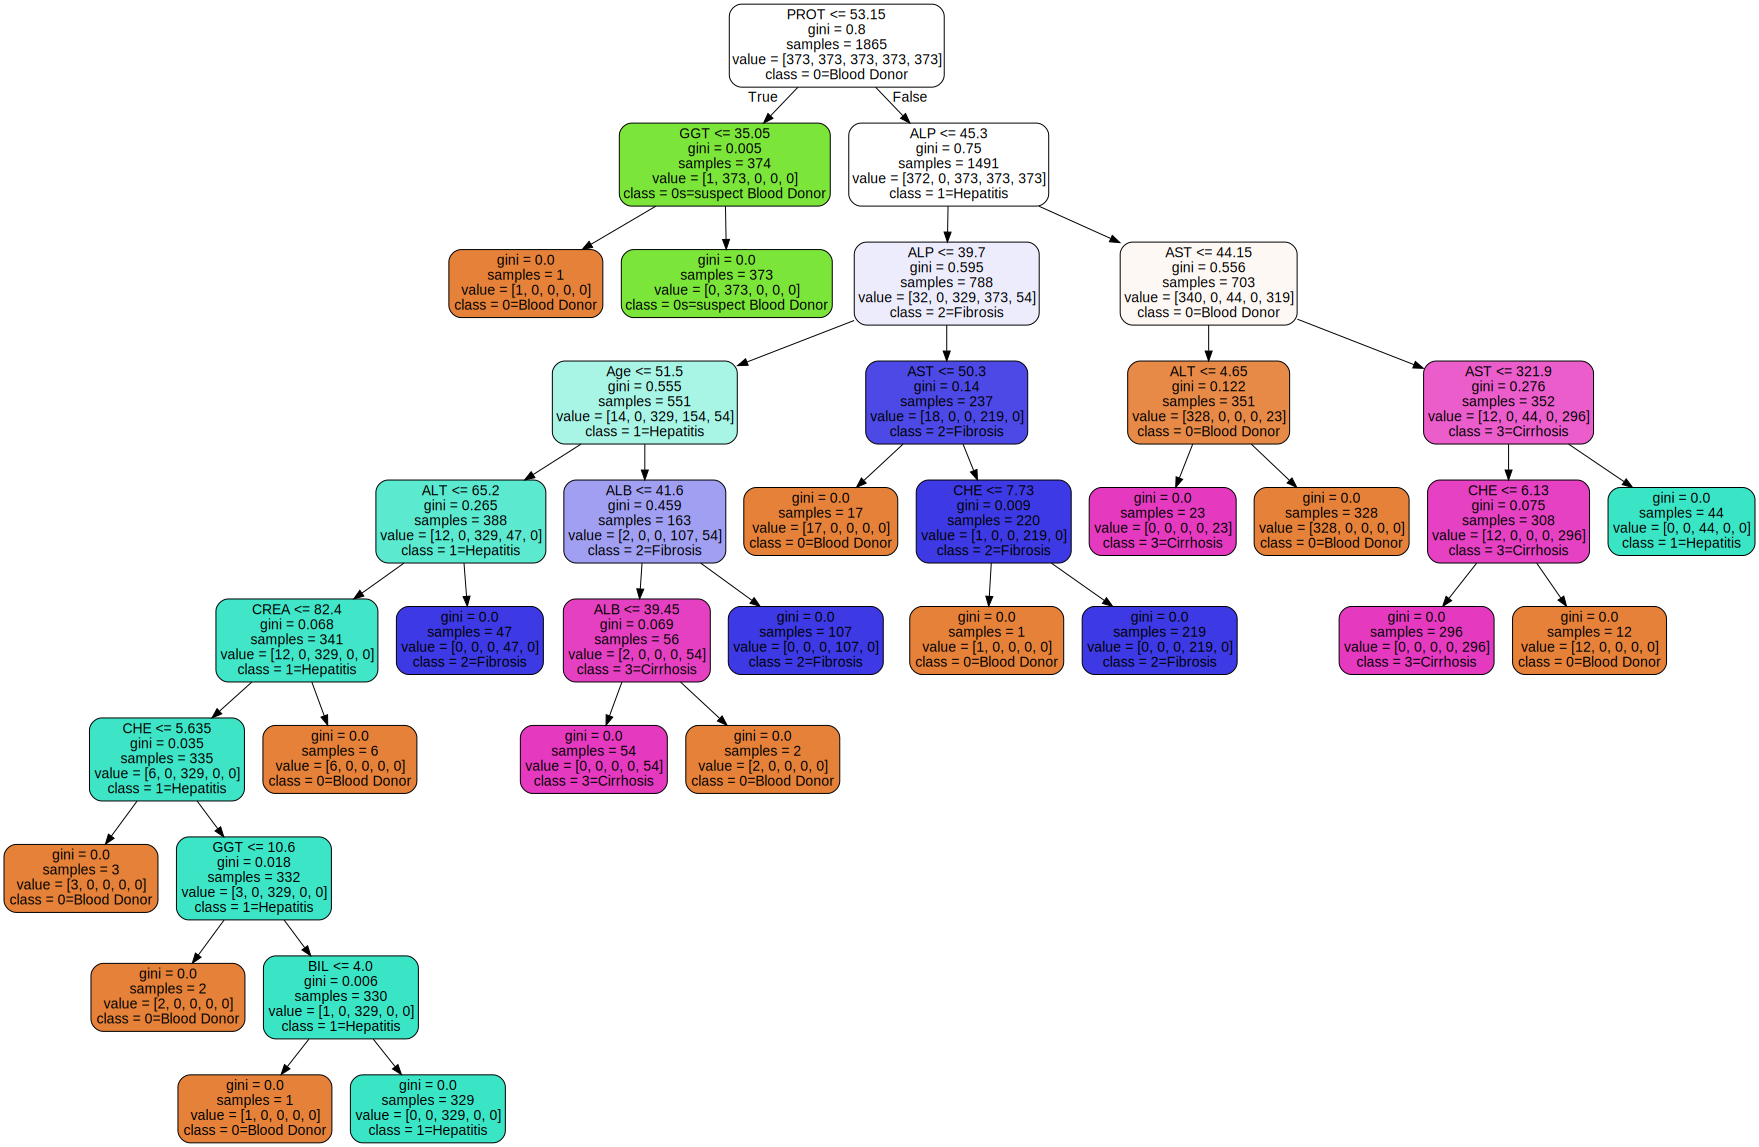

In [28]:
graph

Use ``graph.render('name of the graph', view=True)`` when one wants to save the graph in a pdf file in the same directory as the one containing this notebook.

In [43]:
grid_DT = {'max_depth':np.arange(1,20)}
DT_cv = GridSearchCV(DecisionTreeClassifier(),param_grid=grid_DT)
DT_cv.fit(x_train_eq,y_train_eq)
DT_cv.best_params_

{'max_depth': 12}

In [44]:
DT_cv.score(x_test, y_test)

0.9209039548022598

## Bagging

In [45]:
Bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=12),n_estimators=200)
Bagging.fit(x_train_eq,y_train_eq)
Bagging.score(x_test,y_test)

0.9265536723163842

In [47]:
bagging_grid = {'max_samples':np.arange(0.1,1.1,0.1)}
bagging_cv = GridSearchCV(Bagging,bagging_grid,cv=5)
#bagging_cv.fit(x_train_eq,y_train_eq) #to train on the oversampled training set
bagging_cv.fit(x_train_eq,y_train_eq)
bagging_cv.best_params_

{'max_samples': 0.7000000000000001}

In [48]:
bagging_cv.score(x_test, y_test)

0.9378531073446328

Amélioration de 0.02 par rapport au decision tree seul

## Random forest

In [54]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(x_train_eq,y_train_eq)
RF.score(x_test, y_test)

0.9152542372881356

In [55]:
param_RF = {'max_samples':np.arange(0.1,1,0.1)}
RF_cv = GridSearchCV(RandomForestClassifier(n_estimators=100),param_grid=param_RF,cv=5)
RF_cv.fit(x_train_eq,y_train_eq)
#RF_cv.fit(x_train,y_train)
RF_cv.best_params_

{'max_samples': 0.9}

In [56]:
RF_cv.score(x_test,y_test)

0.9096045197740112

Moins bien que Bagging

## AdaBoost

In [65]:
AdaB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=200)
AdaB.fit(x_train_eq,y_train_eq)
AdaB.score(x_test,y_test)

0.9152542372881356

## Gradient Boosting

In [66]:
GradB = GradientBoostingClassifier(n_estimators=100)
GradB.fit(x_train_eq, y_train_eq)
GradB.score(x_test, y_test)

0.9096045197740112

In [67]:
param_GB = {'learning_rate':np.arange(0.1,0.5,0.1),'max_depth':np.arange(2,5)}
GB_cv = GridSearchCV(GradientBoostingClassifier(n_estimators=100),param_grid=param_GB,cv=2)
#GB_cv.fit(x_train_eq,y_train_eq)
GB_cv.fit(x_train,y_train)
GB_cv.best_params_

{'learning_rate': 0.30000000000000004, 'max_depth': 3}

In [68]:
GB_cv.score(x_test,y_test)

0.9152542372881356

# SVM

## SVM Normal on oversampled dataset

In [69]:
%%time
clf_rbf = SVC(kernel='rbf',C=2.5)
clf_rbf.fit(x_train_eq, y_train_eq)

CPU times: user 50.3 ms, sys: 2.57 ms, total: 52.9 ms
Wall time: 51.2 ms


SVC(C=2.5)

In [70]:
clf_rbf.score(x_test, y_test)

0.9209039548022598

In [79]:
clf_rbf.score(x_train_eq, y_train_eq)

0.9828418230563003

In [72]:
%%time
param_grid = {'C':np.arange(1,10,1),}
clf_rbf_cv = GridSearchCV(clf_rbf, param_grid,cv=2)
clf_rbf_cv.fit(x_train_eq, y_train_eq)
print(clf_rbf_cv.best_params_)

{'C': 5}
CPU times: user 908 ms, sys: 4.97 ms, total: 913 ms
Wall time: 915 ms


In [73]:
clf_rbf_cv.score(x_test, y_test)

0.9265536723163842

In [74]:
clf_rbf_cv.score(x_train_eq, y_train_eq)

0.9839142091152815

## One versus one classification

In [75]:
clf_ovo = SVC(decision_function_shape='ovo')
clf_ovo.fit(x_train, y_train)

SVC(decision_function_shape='ovo')

In [76]:
clf_ovo.score(x_test, y_test)

0.8983050847457628

## One versus rest classification

In [77]:
clf_ovr = SVC(decision_function_shape='ovr')
clf_ovr.fit(x_train, y_train)

SVC()

In [78]:
clf_ovr.score(x_test, y_test)

0.8983050847457628

We obtain the same results with the two different methods

# Neural Network

In [80]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras import optimizers
from keras.utils.np_utils import to_categorical

In [113]:
sc = StandardScaler()
#x_k_train = sc.fit_transform(x_train)
x_k_train = np.array(x_train)
x_k_train = (x_k_train-np.mean(x_k_train,axis=1,keepdims=True))/np.std(x_k_train,axis=1,keepdims=True)
x_k_test = np.array(x_test)
y_k_train = to_categorical(y_train)
y_k_test = to_categorical(y_test)

x_k_train_eq = np.array(x_train_eq)
x_k_train_eq = (x_k_train_eq-np.mean(x_k_train_eq,axis=1,keepdims=True))/np.std(x_k_train_eq,axis=1,keepdims=True)
y_k_train_eq = to_categorical(y_train_eq)

In [216]:
model = Sequential()

model.add(Dense(300, activation='relu', input_dim=12))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [217]:
#weights = {0:len(x_train)/len(y_train[y_train==0]), 1:len(x_train)/len(y_train[y_train==1]),2:len(x_train)/len(y_train[y_train==2]),3:len(x_train)/len(y_train[y_train==3]),4:len(x_train)/len(y_train[y_train==4])}
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(np.array(y_train)),np.array(y_train))

/Users/gregoirebellan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4], y=[3 0 1 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 3 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 4 0 0 4 0 0 0 0 0 0 0 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 4 0
 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 4 4 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0
 4 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 3 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 4
 0 0 0 0 0] as keyword args. From ve

In [218]:
history = model.fit(x_k_train, y_k_train, batch_size = 8, epochs = 100, validation_data=(x_k_test, y_k_test),class_weight = {i:class_weights[i] for i in range(0,5)},verbose=1)

Epoch 1/100
52/52 [==============================] - 1s 5ms/step - loss: 1.7319 - accuracy: 0.0829 - val_loss: 1.4215 - val_accuracy: 0.8418
Epoch 2/100
52/52 [==============================] - 0s 3ms/step - loss: 1.4954 - accuracy: 0.8521 - val_loss: 1.2837 - val_accuracy: 0.8927
Epoch 3/100
52/52 [==============================] - 0s 4ms/step - loss: 1.2192 - accuracy: 0.8717 - val_loss: 1.6149 - val_accuracy: 0.8927
Epoch 4/100
52/52 [==============================] - 0s 4ms/step - loss: 1.1404 - accuracy: 0.8734 - val_loss: 1.7009 - val_accuracy: 0.9096
Epoch 5/100
52/52 [==============================] - 0s 3ms/step - loss: 0.7610 - accuracy: 0.9204 - val_loss: 1.7731 - val_accuracy: 0.9040
Epoch 6/100
52/52 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.9347 - val_loss: 2.7482 - val_accuracy: 0.8644
Epoch 7/100
52/52 [==============================] - 0s 3ms/step - loss: 0.7888 - accuracy: 0.8649 - val_loss: 2.4242 - val_accuracy: 0.9040
Epoch 8/100
5

Epoch 59/100
52/52 [==============================] - 0s 6ms/step - loss: 0.3053 - accuracy: 0.9593 - val_loss: 9.8905 - val_accuracy: 0.9096
Epoch 60/100
52/52 [==============================] - 0s 4ms/step - loss: 0.1314 - accuracy: 0.9656 - val_loss: 8.5340 - val_accuracy: 0.9209
Epoch 61/100
52/52 [==============================] - 0s 4ms/step - loss: 0.1739 - accuracy: 0.9620 - val_loss: 9.1134 - val_accuracy: 0.9322
Epoch 62/100
52/52 [==============================] - 0s 5ms/step - loss: 0.1192 - accuracy: 0.9681 - val_loss: 9.5117 - val_accuracy: 0.9153
Epoch 63/100
52/52 [==============================] - 0s 4ms/step - loss: 0.2972 - accuracy: 0.9642 - val_loss: 8.7581 - val_accuracy: 0.9322
Epoch 64/100
52/52 [==============================] - 0s 3ms/step - loss: 0.2546 - accuracy: 0.9578 - val_loss: 9.0268 - val_accuracy: 0.9266
Epoch 65/100
52/52 [==============================] - 0s 3ms/step - loss: 0.1564 - accuracy: 0.9660 - val_loss: 9.4547 - val_accuracy: 0.9322
Epoch 

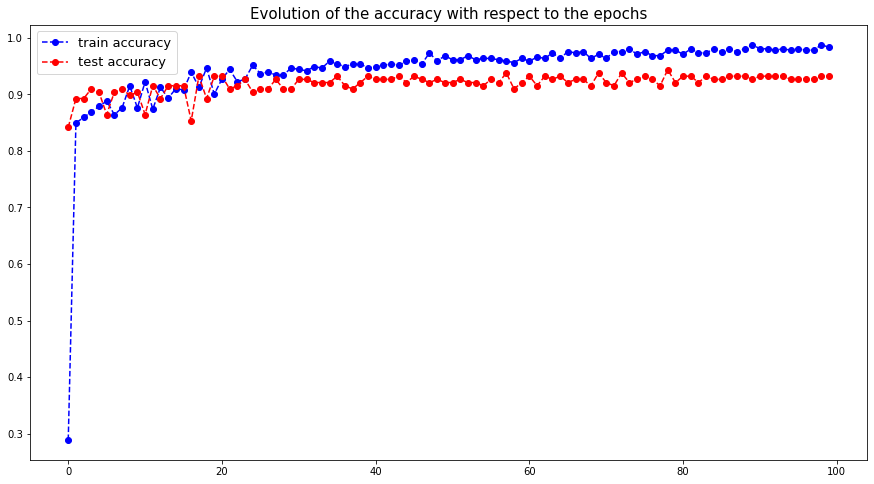

In [219]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
plt.figure(figsize=(15,8))
plt.plot(loss, c='b', marker='o', linestyle='--', label='train accuracy')
plt.plot(val_loss, c='r', marker='o', linestyle='--', label='test accuracy')
plt.title('Evolution of the accuracy with respect to the epochs', size=15)
plt.legend(fontsize=13)
plt.show()